In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import corner
import os
import sys
import glob
from copy import deepcopy
from astropy.io import fits
from scipy import stats

import aesara_theano_fallback.tensor as T
from   aesara_theano_fallback import aesara as theano
import pymc3 as pm
import pymc3_ext as pmx
import corner

PROJECT_DIR = '/Users/research/projects/kepler-ecc-rp/'

sys.path.append(PROJECT_DIR)
from utils.stats import weighted_percentile
from utils.io import load_posteriors, extract_posteriors

pi = np.pi

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


## Metallicity

In [2]:
PATH = os.path.join(PROJECT_DIR, 'Results/20241016/alderaan-all-LC-metallicity/')
files = list(np.sort(glob.glob(os.path.join(PATH, '*.fits'))))

samples, headers, bin_edges = load_posteriors(files)
rp, ecc, mult, nobj = extract_posteriors(samples, headers)


feh = np.zeros_like(rp)
for i, s in enumerate(samples):
    head = headers[i]
    feh[i] = (head['FEH_0'], head['FEH_1'])

In [3]:
colors = ['C3', 'C1', 'C0', 'C2', 'C4']
labels = ['Jovians', 'sub-Saturns', 'sub-Neptunes', 'super-Earths', 'sub-Earths']

Ter = rp[:,0] == 0.5
SE  = rp[:,0] == 1.0
SN  = rp[:,0] == 1.84
SS  = rp[:,0] == 4.0
Jov = rp[:,0] == 8.0

planet_groups = [Jov, SS, SN, SE, Ter]

In [4]:
x_pred = np.linspace(-0.5,0.5,100)
feh_traces = []

for i, pgroup in enumerate(planet_groups):
    x = np.mean(feh[pgroup], axis=1)
    y = np.percentile(ecc[pgroup], [16,50,84], axis=1)
    
    y_obs = y[1]
    y_err = np.abs(y[(0,2),:]-y[1])
    
    with pm.Model() as model:
        m = pm.Normal("m", mu=0, sd=1, testval=0)
        b = pm.Uniform("b", lower=0, upper=1, testval=np.mean(y_obs))
    
        y_mod = pm.Deterministic("y_mod", m*x + b)
        y_pred = pm.Deterministic("y_pred", m*x_pred + b)
        obs = pm.Normal("obs", mu=y_mod, sd=y_err, observed=y_obs)

    with model:
        feh_traces.append(pmx.sample(tune=2000, draws=1000, chains=2, target_accept=0.95, return_inferencedata=True))

Multiprocess sampling (2 chains in 4 jobs)
NUTS: [b, m]


/opt/homebrew/anaconda3/envs/kepler-ecc-rp/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/anaconda3/envs/kepler-ecc-rp/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 2 seconds.
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [b, m]


/opt/homebrew/anaconda3/envs/kepler-ecc-rp/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/anaconda3/envs/kepler-ecc-rp/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 1 seconds.
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [b, m]


/opt/homebrew/anaconda3/envs/kepler-ecc-rp/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/anaconda3/envs/kepler-ecc-rp/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 1 seconds.
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [b, m]


/opt/homebrew/anaconda3/envs/kepler-ecc-rp/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/anaconda3/envs/kepler-ecc-rp/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 1 seconds.
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [b, m]


/opt/homebrew/anaconda3/envs/kepler-ecc-rp/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/anaconda3/envs/kepler-ecc-rp/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 1 seconds.


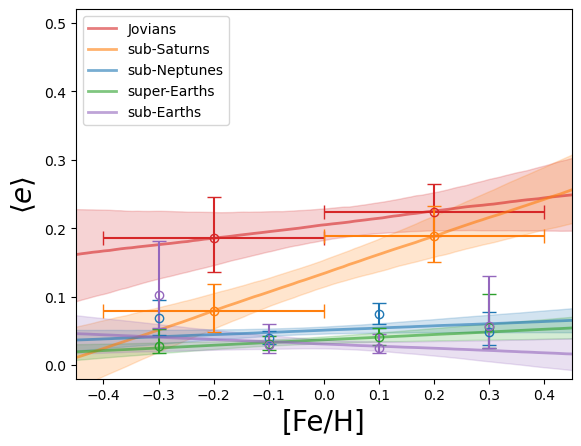

In [5]:
plt.figure()

for i, pgroup in enumerate(planet_groups):
    x = np.mean(feh[pgroup], axis=1)
    y = np.percentile(ecc[pgroup], [16,50,84], axis=1)
    
    if (labels[i] == 'Jovians') or (labels[i] == 'sub-Saturns'):
        xerr = np.abs(feh[pgroup].T - x)
    else:
        xerr = None
    
    yobs = y[1]
    yerr = np.abs(y[(0,2),:]-y[1])
    
    xfit = x_pred
    yfit = np.percentile(feh_traces[i].posterior.y_pred, [16,50,84], axis=(0,1))
    
    plt.errorbar(x, yobs, yerr=yerr, xerr=xerr, fmt='o', color=colors[i], capsize=5, fillstyle='none')
    plt.plot(xfit, yfit[1], color=colors[i], lw=2, alpha=0.6, label=labels[i])
    plt.fill_between(xfit, yfit[0], yfit[2], color=colors[i], alpha=0.2)

plt.xlim(-0.45,0.45)
plt.ylim(-0.02,0.52)
plt.xlabel("[Fe/H]", fontsize=20)
plt.ylabel(r"$\langle e \rangle$", fontsize=20)
plt.legend(loc='upper left')
plt.savefig(os.path.join(PROJECT_DIR, 'Figures/ecc-metallicity.pdf'), bbox_inches='tight')
plt.show()

In [6]:
for i, pgroup in enumerate(planet_groups):
    slope = np.percentile(feh_traces[i].posterior.m, [16,50,84], axis=(0,1))
    
    mu = slope[1]
    sd = 0.5*(slope[2]-slope[0])
    
    print("{0}: \t {1:.3f} +/-  {2:.3f} ({3:.1f} sigma)".format(labels[i], mu, sd, mu/sd))

Jovians: 	 0.099 +/-  0.124 (0.8 sigma)
sub-Saturns: 	 0.271 +/-  0.097 (2.8 sigma)
sub-Neptunes: 	 0.032 +/-  0.034 (0.9 sigma)
super-Earths: 	 0.039 +/-  0.029 (1.4 sigma)
sub-Earths: 	 -0.032 +/-  0.057 (-0.6 sigma)


## Period

In [7]:
PATH = os.path.join(PROJECT_DIR, 'Results/20241007/alderaan-all-LC-period/')
files = list(np.sort(glob.glob(os.path.join(PATH, '*.fits'))))

samples, headers, bin_edges = load_posteriors(files)
rp, ecc, mult, nobj = extract_posteriors(samples, headers)


per = np.zeros_like(rp)
for i, s in enumerate(samples):
    head = headers[i]
    per[i] = (head['PER_0'], head['PER_1'])

In [8]:
colors = ['C3', 'C1', 'C0', 'C2', 'C4']
labels = ['Jovians', 'sub-Saturns', 'sub-Neptunes', 'super-Earths', 'sub-Earths']

Ter = rp[:,0] == 0.5
SE  = rp[:,0] == 1.0
SN  = rp[:,0] == 1.84
SS  = rp[:,0] == 4.0
Jov = rp[:,0] == 8.0

planet_groups = [Jov, SS, SN, SE, Ter]

In [9]:
x_pred = np.linspace(np.log10(0.3),np.log10(300),100)
per_traces = []

for i, pgroup in enumerate(planet_groups):
    x = np.mean(np.log10(per[pgroup]), axis=1)
    y = np.percentile(ecc[pgroup], [16,50,84], axis=1)
    
    y_obs = y[1]
    y_err = np.abs(y[(0,2),:]-y[1])
    
    with pm.Model() as model:
        m = pm.Normal("m", mu=0, sd=1, testval=0)
        b = pm.Uniform("b", lower=0, upper=1, testval=np.mean(y_obs))
    
        y_mod = pm.Deterministic("y_mod", m*x + b)
        y_pred = pm.Deterministic("y_pred", m*x_pred + b)
        obs = pm.Normal("obs", mu=y_mod, sd=y_err, observed=y_obs)

    with model:
        per_traces.append(pmx.sample(tune=2000, draws=1000, chains=2, target_accept=0.95, return_inferencedata=True))

Multiprocess sampling (2 chains in 4 jobs)
NUTS: [b, m]


/opt/homebrew/anaconda3/envs/kepler-ecc-rp/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/anaconda3/envs/kepler-ecc-rp/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 1 seconds.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [b, m]


/opt/homebrew/anaconda3/envs/kepler-ecc-rp/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/anaconda3/envs/kepler-ecc-rp/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 1 seconds.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [b, m]


/opt/homebrew/anaconda3/envs/kepler-ecc-rp/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/anaconda3/envs/kepler-ecc-rp/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 1 seconds.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [b, m]


/opt/homebrew/anaconda3/envs/kepler-ecc-rp/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/anaconda3/envs/kepler-ecc-rp/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 1 seconds.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [b, m]


/opt/homebrew/anaconda3/envs/kepler-ecc-rp/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/anaconda3/envs/kepler-ecc-rp/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 1 seconds.
The number of effective samples is smaller than 25% for some parameters.


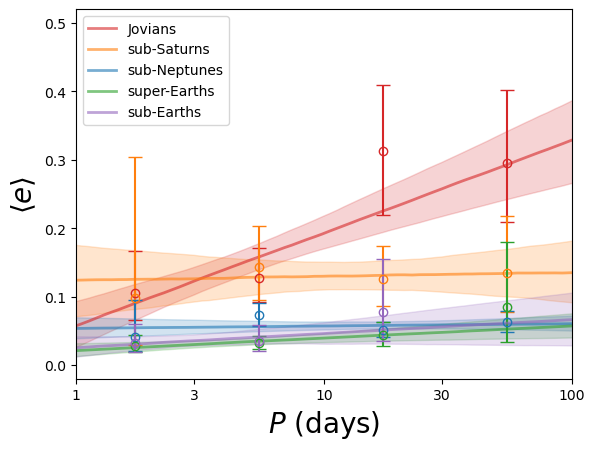

In [10]:
plt.figure()

for i, pgroup in enumerate(planet_groups):
    x = np.mean(np.log10(per[pgroup]), axis=1)
    y = np.percentile(ecc[pgroup], [16,50,84], axis=1)
    
    yobs = y[1]
    yerr = np.abs(y[(0,2),:]-y[1])

    xfit = x_pred
    yfit = np.percentile(per_traces[i].posterior.y_pred, [16,50,84], axis=(0,1))
    
    plt.errorbar(x, yobs, yerr=yerr, fmt='o', color=colors[i], capsize=5, fillstyle='none')
    plt.plot(xfit, yfit[1], color=colors[i], lw=2, alpha=0.6, label=labels[i])
    plt.fill_between(xfit, yfit[0], yfit[2], color=colors[i], alpha=0.2)

plt.xlim(np.log10(1),np.log10(100))
plt.xticks(np.log10([1,3,10,30,100]),[1,3,10,30,100])
plt.ylim(-0.02,0.52)
plt.xlabel("$P$ (days)", fontsize=20)
plt.ylabel(r"$\langle e \rangle$", fontsize=20)
plt.legend(loc='upper left')
plt.savefig(os.path.join(PROJECT_DIR, 'Figures/ecc-period.pdf'), bbox_inches='tight')
plt.show()

In [11]:
for i, pgroup in enumerate(planet_groups):
    slope = np.percentile(per_traces[i].posterior.m, [16,50,84], axis=(0,1))
    
    mu = slope[1]
    sd = 0.5*(slope[2]-slope[0])
    
    print("{0}: \t {1:.3f} +/-  {2:.3f} ({3:.1f} sigma)".format(labels[i], mu, sd, mu/sd))

Jovians: 	 0.135 +/-  0.042 (3.2 sigma)
sub-Saturns: 	 0.006 +/-  0.044 (0.1 sigma)
sub-Neptunes: 	 0.003 +/-  0.012 (0.3 sigma)
super-Earths: 	 0.018 +/-  0.013 (1.4 sigma)
sub-Earths: 	 0.020 +/-  0.025 (0.8 sigma)
